In [1]:
import json

from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

PROJECT_BASE = Path.home() / 'repos' / 'stcs-6701-hw3' / 'src'

In [2]:
results = {}
for path in sorted((PROJECT_BASE / 'results' / 'mixed_membership' / 'diagonal' / 'full_dataset').glob('*/results.json')):
    K = str(path).split('K')[-1].split('/')[0]
    with open(path) as f:
        r = json.load(f)
        results[int(K)] = r

In [3]:
K_values = list(results.keys())

In [4]:
K_values

[10, 15, 18, 20, 25, 27, 3, 30, 5, 8]

In [5]:
results[3]['log_p_out']

-1484170.0

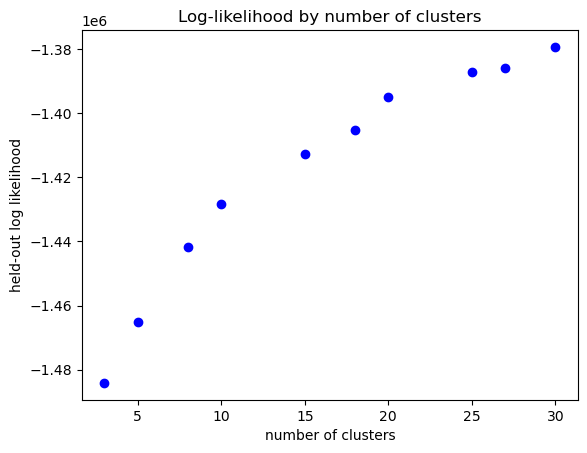

In [6]:
log_ps = [results[K]['log_p_out'] for K in K_values]
plt.plot(K_values, log_ps, 'bo')
plt.xlabel("number of clusters")
plt.ylabel("held-out log likelihood")
plt.title("Log-likelihood by number of clusters")
plt.show()

### predict cluster using this best-performing model

In [7]:
import arviz as az

In [8]:
posterior = az.from_netcdf(PROJECT_BASE / results[30]['netcdf_path'])

In [9]:
posterior

Inference data with groups:
	> posterior
	> sample_stats

In [10]:
df = pd.read_feather(PROJECT_BASE / 'data' / 'df.feather')

In [11]:
df['latent_mean_proj']

0         [-1.1179672479629517, -0.21071967482566833, 0....
1         [-0.7435935735702515, -1.1395747661590576, -0....
2         [-0.7571112513542175, -0.40558552742004395, 0....
3         [-1.813117265701294, -2.306171417236328, -0.87...
4         [-0.3980937600135803, -0.014692068099975586, -...
                                ...                        
583232    [-0.22638572752475739, -0.20343220233917236, 0...
583233    [-3.6328186988830566, -1.4410263299942017, 3.1...
583234    [0.5405005216598511, 0.2650536298751831, 0.338...
583235    [0.10759465396404266, 0.8357921838760376, 0.24...
583236    [0.5006154179573059, -0.1815539002418518, 0.21...
Name: latent_mean_proj, Length: 583237, dtype: object

#### predict the cluster assignment for each datapoint

In [12]:
from scipy.stats import multivariate_normal

from scipy.special import logsumexp

In [13]:
def cluster_log_likelihood(x, beta_k, sigma_k):
    """
    Return the log likelihood of datapoint x given that it came from cluster k.
    
    Specifically, return p(x | z = k, beta, sigma, theta). (theta not an argument
    since x ⟂ theta | z).
    """
    return multivariate_normal.logpdf(x, mean=beta_k, cov=np.diag(np.power(sigma_k, 2)))

In [14]:
def log_p_clusters_given_params(X, cohorts, theta, beta, sigma):
    """
    Return log p(z_i = k | x_i, theta, beta, sigma) for each k, i.
    
    Returns:
        an array of shape (X.shape[0], theta.shape[0]), where each entry ij represents
        p(z_i = j | x_i, theta, beta, sigma).
        
    Details:
    
    Let Omega = {theta, beta, sigma}. Then
        
        p(z_i = k | x_i, Omega) = p(x_i | z_i = k, Omega)p(z_i = k | Omega) / p(x_i | Omega)
                                = f_k(x_i) p(z_i = k| theta) / f(x_i)
                                = theta_k f_k(x_i) / f(x_i)
    
    So log p(z_i = k | x_i, Omega) = log(theta_k) + log f_k(x_i) - log f(x_i)
    """
    N_datapoints = X.shape[0]
    N_cohorts = theta.shape[0]
    K = beta.shape[0]
    log_ps = np.zeros((N_datapoints, K))
    
    log_theta = np.log(theta)
    
    # build theta array based on cohort
    log_theta_per_x = np.zeros((N_datapoints, K))
    
    for i in range(N_cohorts):
        log_theta_per_x[cohorts == i] = log_theta[i]
    
    # p(x_i | z = k, beta, sigma) for each k and i
    # returned shape: (N_datapoints, K)
    cluster_log_ps = np.stack(
        [cluster_log_likelihood(X, beta[k], sigma[k]) for k in range(K)],
        axis=-1
        )

    # p(x_i | beta, theta, sigma) -- full log likelihood of the data point
    # computed as
    #    log_sum_exp(
    #        log theta_1 + log f_k(x_i), ..., log theta_k + log f_k(x_i)
    #    )
    # where f_k(x_i) = p(x_i | z = k, beta, theta, sigma).
    mixture_log_likelihood = logsumexp(log_theta_per_x + cluster_log_ps, axis=1)
    
    # log theta per x: (N_datapoints, K)
    # cluster_log_ps: (N_datapoints, K)
    # mixture_log_likelihood: (N_datapoints)
    log_ps = log_theta_per_x + cluster_log_ps - mixture_log_likelihood[:, None]
        
    return np.array(log_ps)

In [15]:
get_sample = lambda param: posterior.posterior[param][0, 0]

theta = get_sample('theta')
beta = get_sample('beta')
sigma = get_sample('sigma')

In [16]:
COHORT_MAP = {'c2': 0, 'c4': 1, 'c5': 2}

In [17]:
df['cohort_int'] = df['cohort'].map(COHORT_MAP)

In [18]:
log_p_clusters_given_params(
    np.stack(df['latent_mean_proj'].to_numpy()),
    df['cohort_int'],
    theta,
    beta,
    sigma
)

array([[ -6.8745899 , -25.14399595, -12.93641077, ...,  -6.00374973,
         -6.32460662, -18.49031686],
       [ -5.54390605, -28.02161745, -15.48357172, ...,  -7.24724745,
         -9.71187199, -15.96230786],
       [ -7.42903223, -17.61456153, -14.37006975, ...,  -6.26012477,
         -5.75312017, -16.12630661],
       ...,
       [ -9.87003781, -14.96616121,  -3.42646393, ..., -13.9705492 ,
        -11.17054206, -13.45416822],
       [ -6.06914111,  -8.23466586,  -6.64595062, ...,  -8.66179756,
         -4.52154876, -11.16896978],
       [-10.02935856, -12.29017577,  -4.58107262, ..., -12.80050938,
        -10.00142973, -13.30882647]])

In [19]:
def log_p_clusters(X, cohorts, posterior):
    """
    Return log p(z_i = k | x_i) for each k, i.
    
    Let Omega = {beta, L, sigma, theta}. Then
    
        p(z_i = k | x_i) = integral p(z_i = k | x_i, Omega) p(Omega | x_i) d Omega
                         ≈ 1/N sum_{n = 1}^N p(z_i | x_i, Omega_n),
    
    where N is the number of samples from the posterior (this is a Monte Carlo estimate
    of the integral).
    
    We calculate the logarithm as follows:
    
        log p(z_i = k | x_i) =  log_sum_exp( log p(z_i = k | x_i, Omega_1) , ..., log p(z_i = k| x_i, Omega_N) ) - log(N)
    """
    N_samples = len(posterior.draw)
    N_datapoints = X.shape[0]
    K = posterior.theta.shape[-1]  # shape: (num_draws, num_components)
    
    log_p_per_sample = np.zeros((N_samples, N_datapoints, K))
    
    for n in range(N_samples):
        log_p_per_sample[n] = log_p_clusters_given_params(
            X,
            cohorts,
            posterior.theta[n],
            posterior.beta[n],
            posterior.sigma[n]
        )
    
    # now calculate log p(z_i = k | x_i) for each k using log sum exp
    return logsumexp(log_p_per_sample, axis=0) - np.log(N_samples)

In [20]:
df['log_p_z_K30'] = [
    x for x in log_p_clusters(
        np.stack(df['latent_mean_proj'].to_numpy()),
        df['cohort_int'],
        posterior.posterior.squeeze()
    )
]

In [21]:
df['log_p_z_K30']

0         [-6.871295371737645, -25.096547733323053, -12....
1         [-5.545037288068974, -27.97826038871344, -15.4...
2         [-7.425324131063482, -17.589314539581004, -14....
3         [-1.516927016138113, -46.1090007618253, -23.51...
4         [-7.515993642845994, -24.04164770164726, -15.3...
                                ...                        
583232    [-8.794170969381133, -19.883777833883755, -0.2...
583233    [-0.12343076413388232, -140.41995644872975, -3...
583234    [-9.869881196096358, -14.957904167486298, -3.4...
583235    [-6.070245371836747, -8.232617146792936, -6.64...
583236    [-10.030700809242816, -12.284783291268365, -4....
Name: log_p_z_K30, Length: 583237, dtype: object

In [22]:
df['z'] = df['log_p_z_K30'].apply(lambda x: x.argmax())

In [23]:
df['z']

0         19
1         20
2         19
3         20
4         25
          ..
583232     2
583233     0
583234     8
583235    16
583236     8
Name: z, Length: 583237, dtype: int64

In [24]:
sorted(df['z'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [25]:
import seaborn as sns

K = theta.shape[-1]

cmap = sns.color_palette("muted", K)

In [26]:
from matplotlib.colors import ListedColormap

In [27]:
cmap = ListedColormap(sns.color_palette(n_colors=K).as_hex())

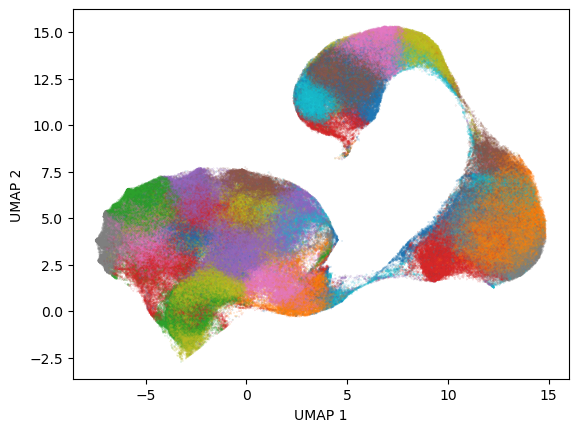

In [35]:
plt.scatter(
    *np.stack(df['latent_mean_umap'].to_numpy()).T,
    c=df['z'].values,
    cmap=cmap,
    s=0.005
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [29]:
THRESHOLDS = (0.5, 0.8, 0.9, 0.95)
K_VALUE = 30
for threshold in THRESHOLDS:
    df[f'{threshold}_confident_assignments_K{K_VALUE}'] = df[f'log_p_z_K{K_VALUE}'].apply(lambda x: x.argmax() if np.exp(x).max() > threshold else -1)
    print(f"at threshold {threshold}, proportion assigned: {((df[f'{threshold}_confident_assignments_K{K_VALUE}'] != -1).sum() / len(df)):0.3f}")

at threshold 0.5, proportion assigned: 0.903
at threshold 0.8, proportion assigned: 0.552
at threshold 0.9, proportion assigned: 0.383
at threshold 0.95, proportion assigned: 0.253


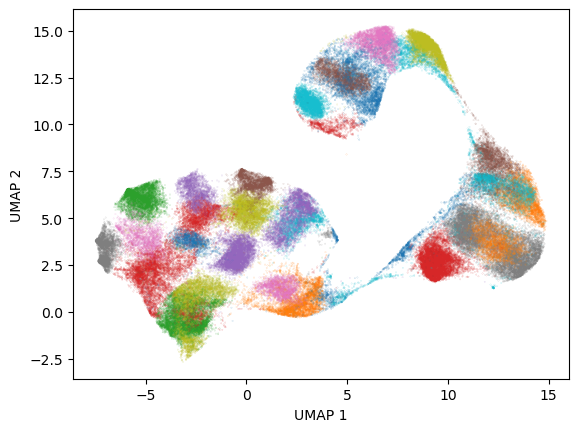

In [36]:
confident_points = df.loc[df['0.95_confident_assignments_K30'] != -1]
plt.scatter(
    *np.stack(confident_points['latent_mean_umap'].to_numpy()).T,
    c=confident_points['z'].values,
    cmap=cmap,
    s=0.005
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

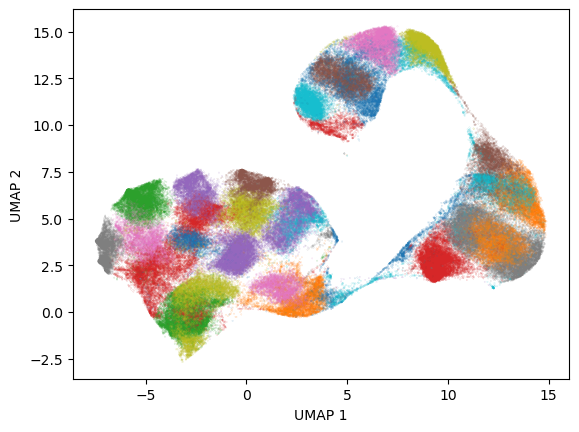

In [37]:
confident_points = df.loc[df['0.9_confident_assignments_K30'] != -1]
plt.scatter(
    *np.stack(confident_points['latent_mean_umap'].to_numpy()).T,
    c=confident_points['z'].values,
    cmap=cmap,
    s=0.005
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

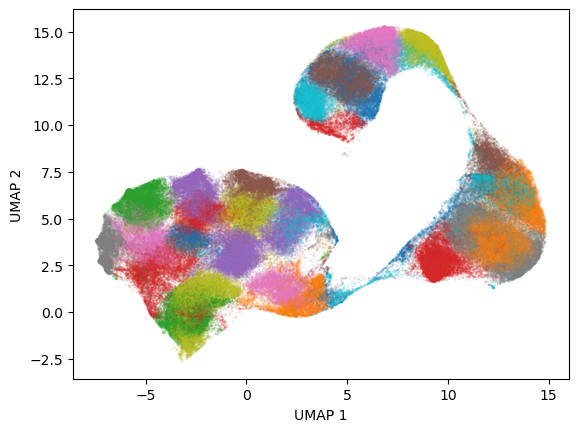

In [38]:
confident_points = df.loc[df['0.8_confident_assignments_K30'] != -1]
plt.scatter(
    *np.stack(confident_points['latent_mean_umap'].to_numpy()).T,
    c=confident_points['z'].values,
    cmap=cmap,
    s=0.005
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

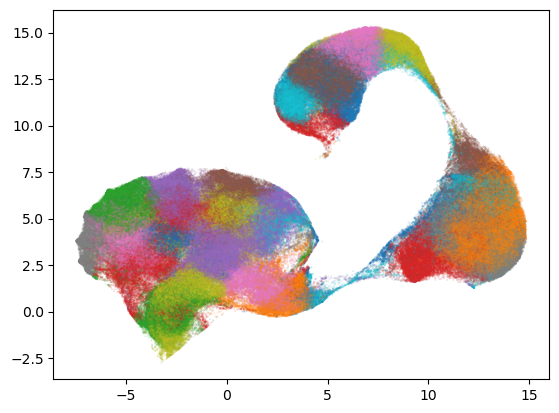

In [33]:
confident_points = df.loc[df['0.5_confident_assignments_K30'] != -1]
plt.scatter(
    *np.stack(confident_points['latent_mean_umap'].to_numpy()).T,
    c=confident_points['z'].values,
    cmap=cmap,
    s=0.005
)
plt.show()

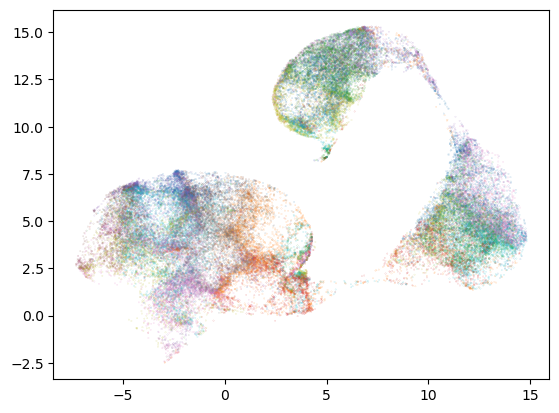

In [538]:
# df['boundaries'] = df['test'].apply(lambda x: x.argmax() if np.exp(x).max() < 0.5 else -1)
# boundary_pts = df.loc[df['boundaries'] != -1]
# plt.scatter(
#     *np.stack(boundary_pts['latent_mean_umap'].to_numpy()).T,
#     c=boundary_pts['test_assignments'].values,
#     cmap=cmap,
#     s=0.005
# )
# plt.show()

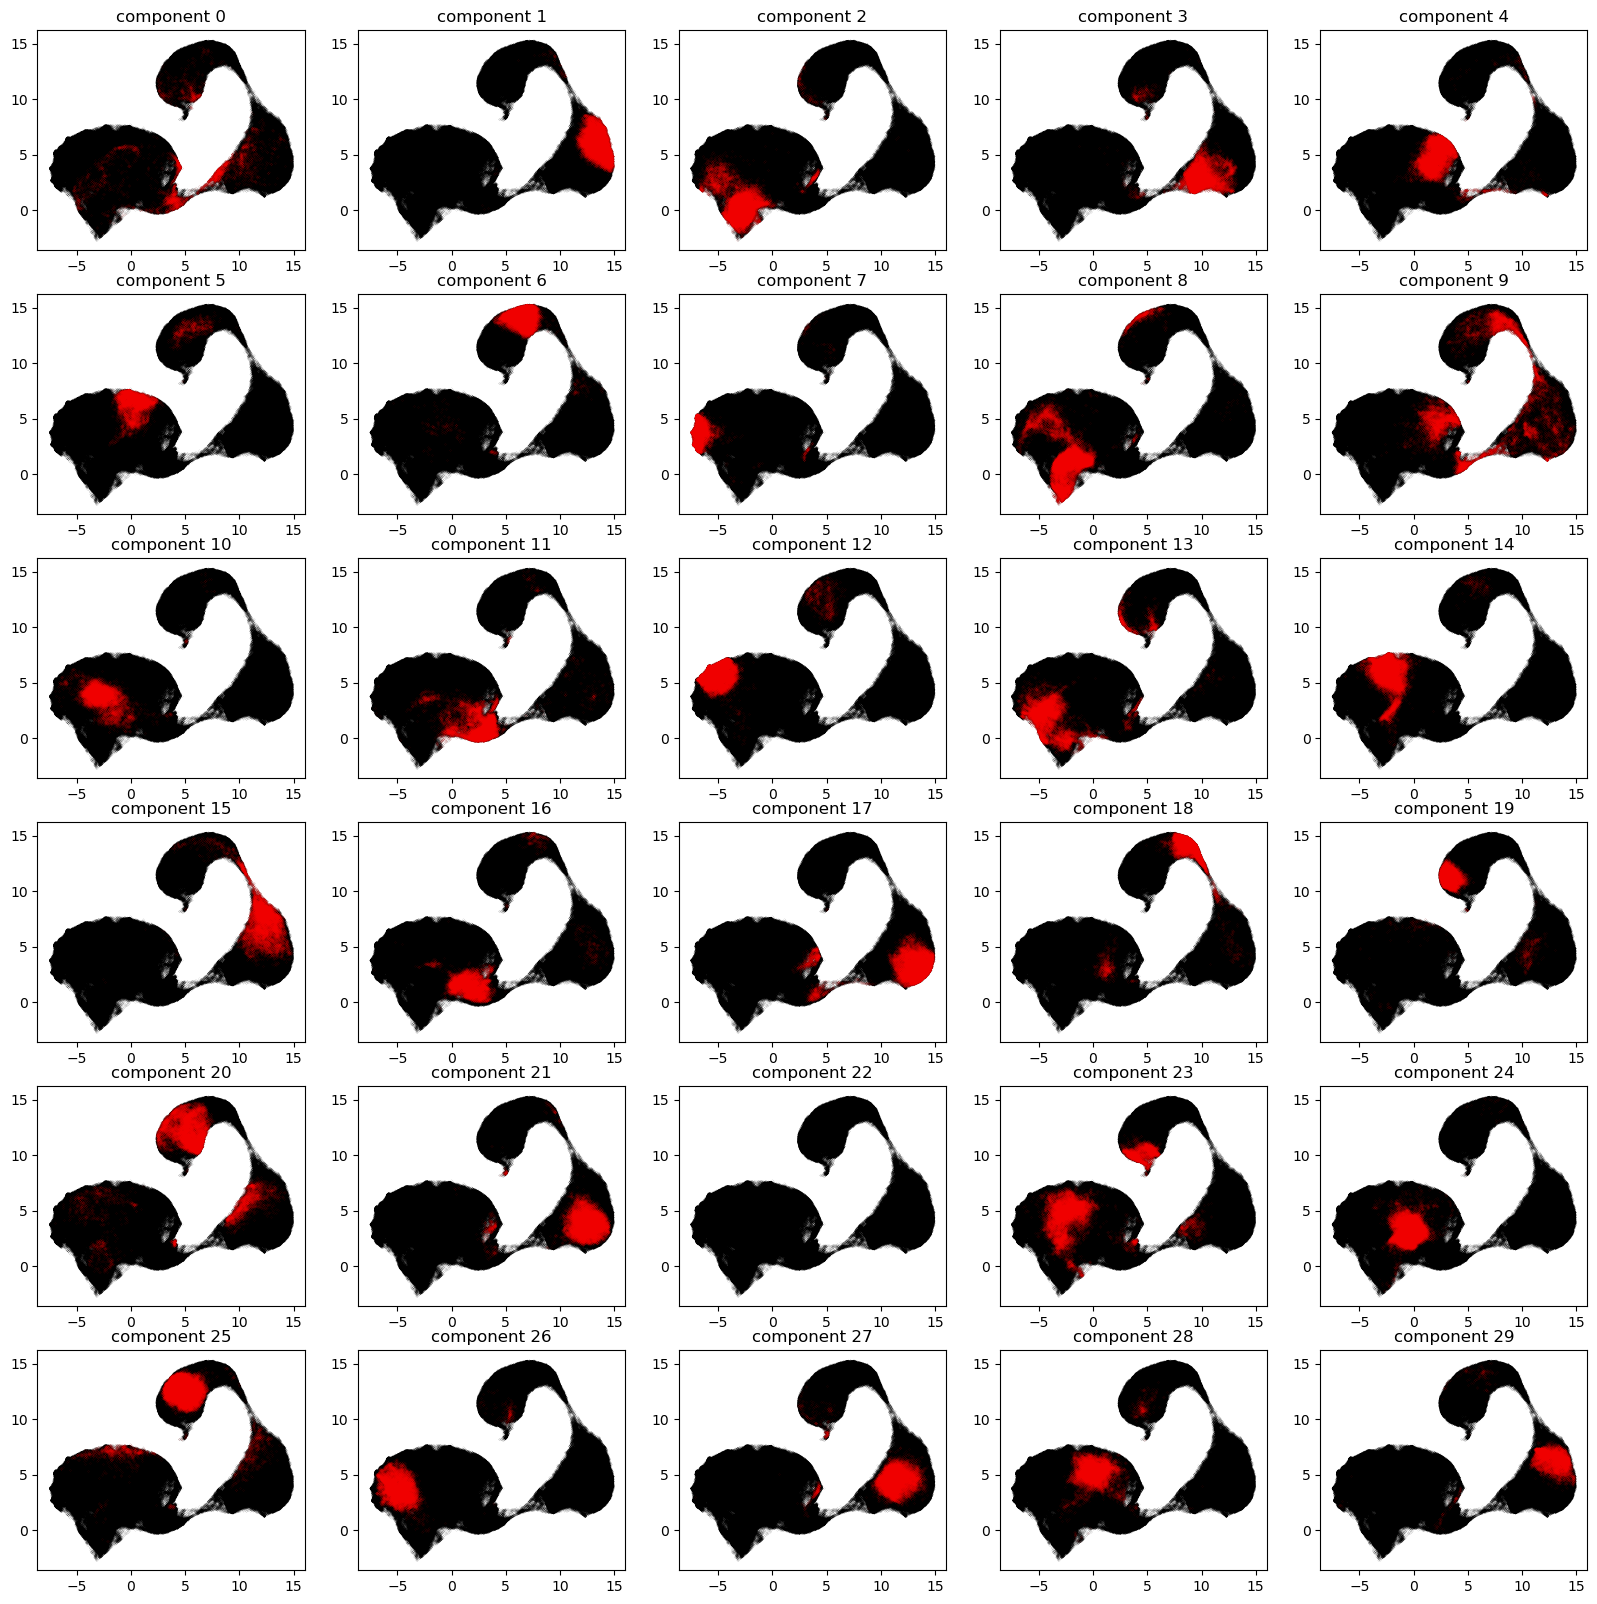

In [34]:
fig, axs = plt.subplots(6, 5, figsize=(20, 20))

i = 0
for ax_row in axs:
    for ax in ax_row:
        ax.scatter(
            *np.stack(df['latent_mean_umap'].to_numpy()).T,
            c='black',
            s=0.0015
        )
        cluster_i = df.loc[df['z'] == i, 'latent_mean_umap'].to_numpy()
        if not cluster_i.size == 0:
            ax.scatter(
                *np.stack(cluster_i).T,
                c='red',
                s=0.002
            )
        # cluster_i = df.loc[df['0.9_confident_assignments_K30'] == i, 'latent_mean_umap'].to_numpy()
        # if not cluster_i.size == 0:
        #     ax.scatter(
        #         *np.stack(cluster_i).T,
        #         c='blue',
        #         s=0.002
        #     )
        ax.set_title(f'component {i}')
        i += 1
    
plt.show()

### plot reconstructed samples that were assigned with > 0.9 confidence

In [39]:
# load vae

from ava.models.vae import VAE

vae = VAE(save_dir='vae')
vae.load_state(PROJECT_BASE / 'aux' / 'vae_checkpoint.tar')
%matplotlib inline

/mnt/home/achoudhri/miniconda3/envs/gerbiLDA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import torch

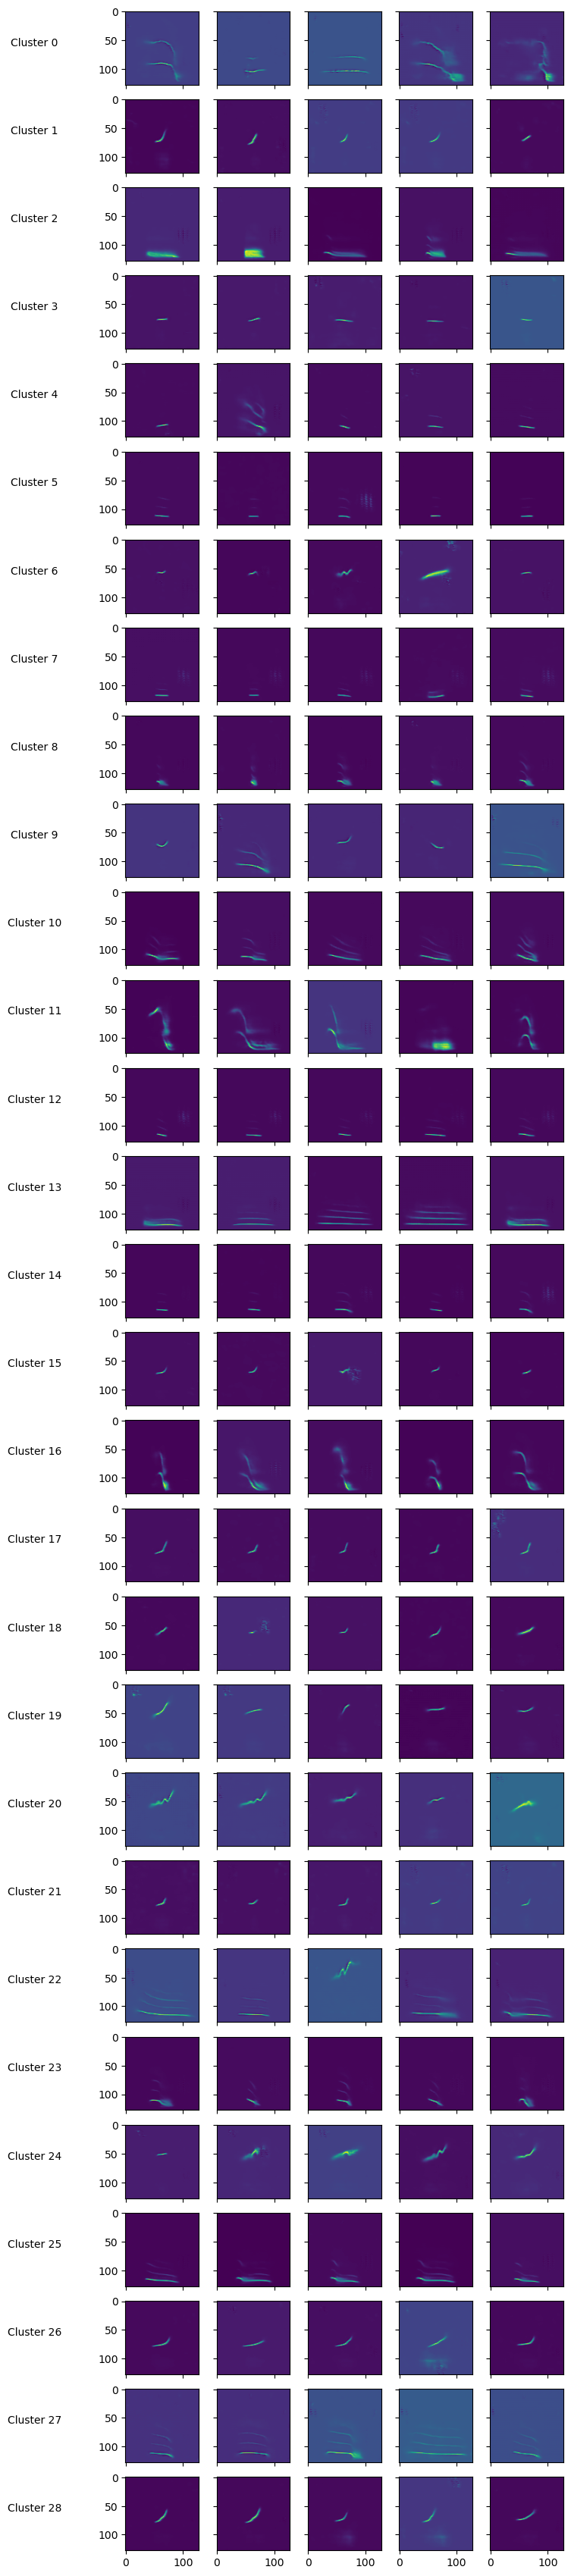

In [41]:
high_confidence_points = df.loc[df['0.9_confident_assignments_K30'] != -1]

ORIGINAL_SHAPE = (128, 128)

# get five from each
clusters = sorted(high_confidence_points['0.9_confident_assignments_K30'].unique())
N_to_plot = 5
fig, axs = plt.subplots(
    len(clusters), N_to_plot, figsize=(1.5 * N_to_plot, 1.5 * len(clusters)),
    sharex=True,
    sharey=True
)

for ax_row, cluster_id in zip(axs, clusters):
    latent_means = high_confidence_points.loc[
        high_confidence_points['0.9_confident_assignments_K30'] == cluster_id,
        ['latent_means']
    ].sample(5)

    with torch.no_grad():
        spectrograms = vae.decode(torch.tensor(np.stack(latent_means.to_numpy().squeeze()), dtype=torch.float))

    for ax, spectrogram in zip(ax_row, spectrograms):
        img = np.array(spectrogram.reshape(*ORIGINAL_SHAPE))[::-1]
        ax.imshow(img)

for i in range(len(clusters)):
    axs[i][0].set_ylabel(f'Cluster {i}', rotation=0, labelpad=60)
plt.show()

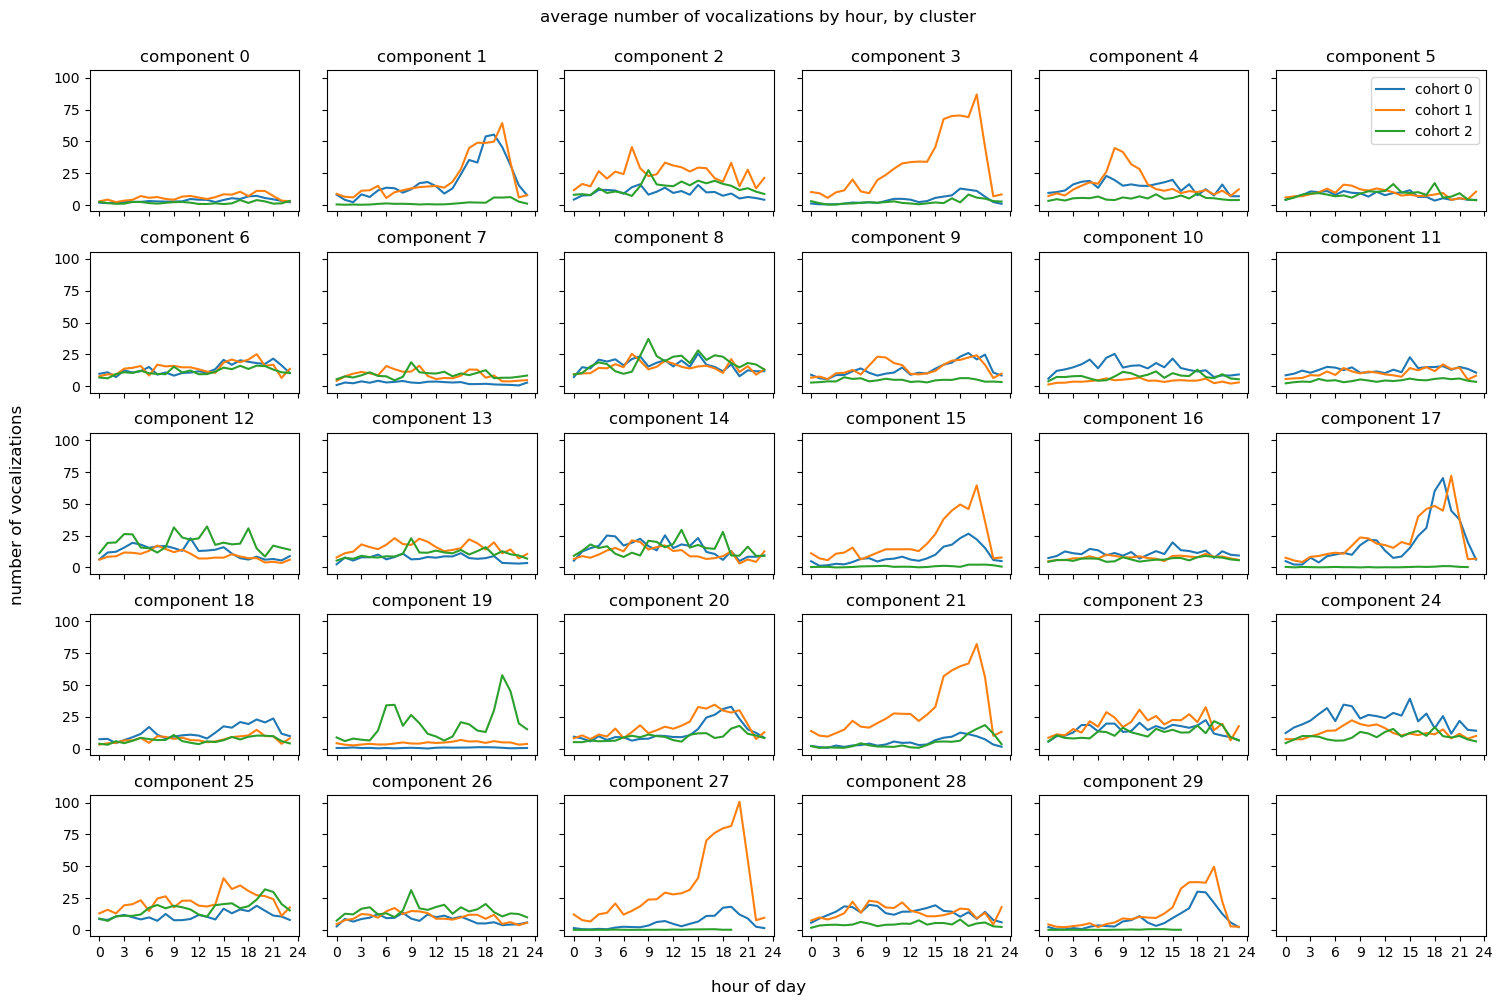

In [42]:
cluster_idxs = sorted(df['z'].unique())
n_assigned_per_hour = df.groupby(['z', 'hour_of_day']).size() / df['date'].nunique()

fig, axs = plt.subplots(5, 6, figsize=(15, 10), sharex=True, sharey=True)

i = 0
for ax_row in axs:
    for ax in ax_row:
        if i == 29: break # one cluster wasn't really used
        # ax.set_xticks(np.arange(0, 21, 2), np.arange(14, 14+21, 2))
        for j in range(3):
            counts = df.loc[df['cohort_int'] == j].groupby(['z', 'hour_of_day']).size()[cluster_idxs[i]].to_numpy()
            ax.plot(counts / df['hour_of_day'].nunique(), label=f'cohort {j}')
        ax.set_title(f'component {cluster_idxs[i]}')
        ax.set_xticks(np.arange(9) * 3)
        i += 1
        
fig.supxlabel('hour of day')
fig.supylabel('number of vocalizations', x=0.001)

fig.suptitle('average number of vocalizations by hour, by cluster', y=0.995)
fig.tight_layout()
axs[0][-1].legend()
plt.show()

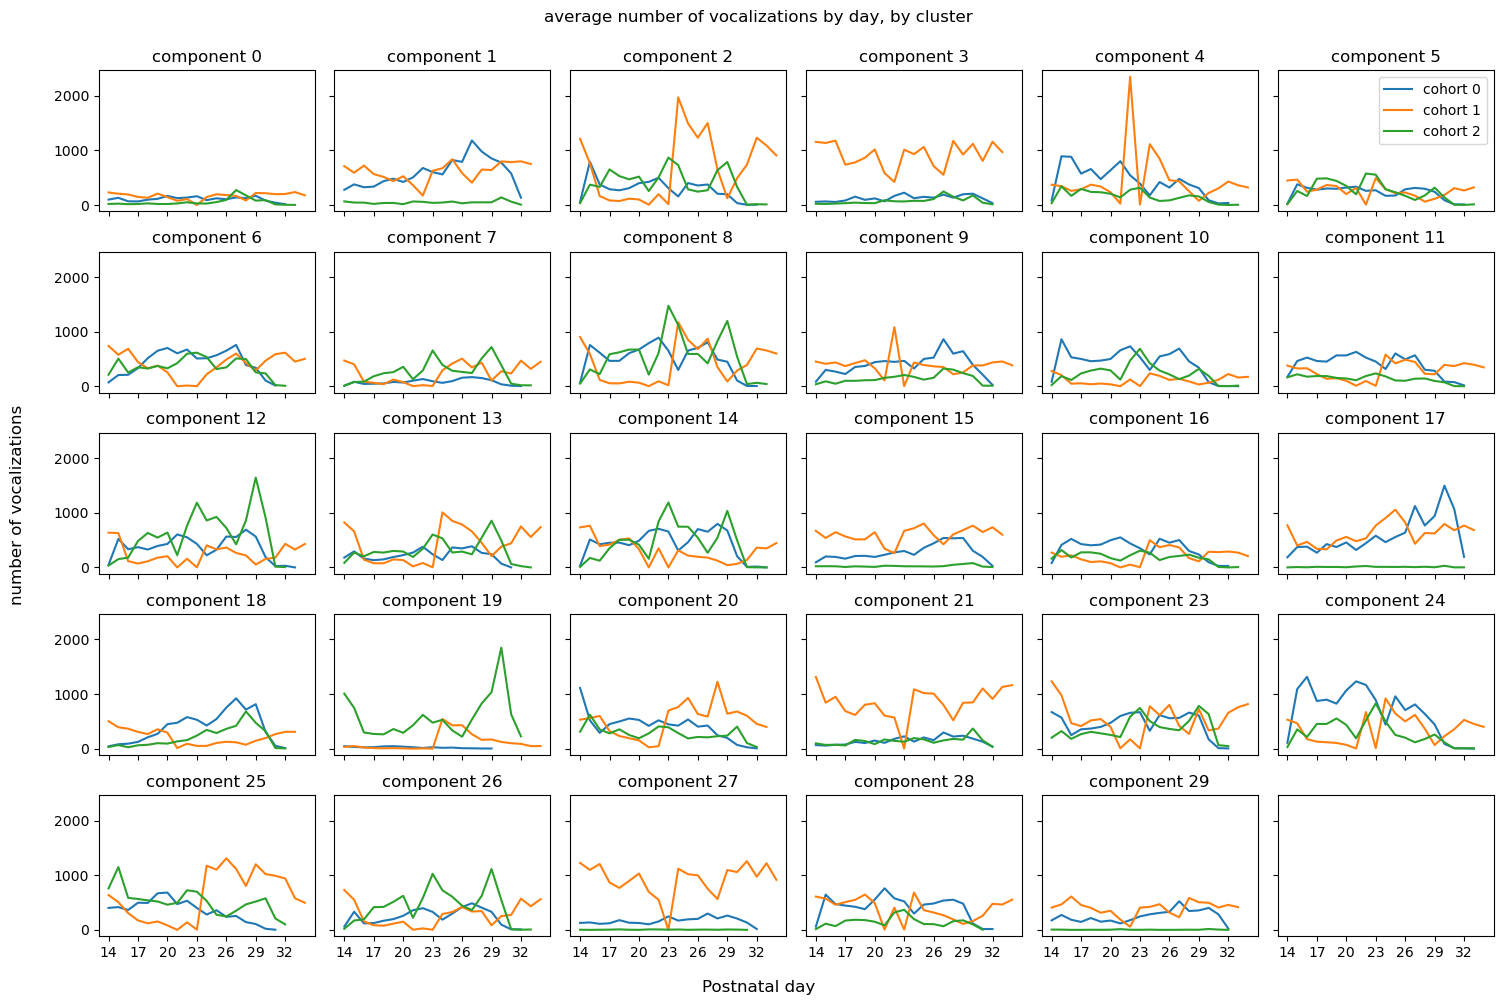

In [43]:
cluster_idxs = sorted(df['z'].unique())
n_assigned_per_day = df.loc[df['cohort_int'] == 0].groupby(['z', 'date']).size()

fig, axs = plt.subplots(5, 6, figsize=(15, 10), sharex=True, sharey=True)

i = 0
for ax_row in axs:
    for ax in ax_row:
        if i == 29: break
        ax.set_xticks(np.arange(0, 21, 3), np.arange(14, 14+21, 3))
        for j in range(3):
            counts = df.loc[df['cohort_int'] == j].groupby(['z', 'date']).size()[cluster_idxs[i]].to_numpy()
            ax.plot(counts, label=f'cohort {j}')
        ax.set_title(f'component {cluster_idxs[i]}')
        # ax.locator_params(nbins=10)
        days = n_assigned_per_day[cluster_idxs[i]].index
        i += 1
        
axs[0][-1].legend(loc='upper right')
fig.supxlabel('Postnatal day')
fig.supylabel('number of vocalizations', x=0.001)

fig.suptitle('average number of vocalizations by day, by cluster', y=0.995)
fig.tight_layout()
plt.show()

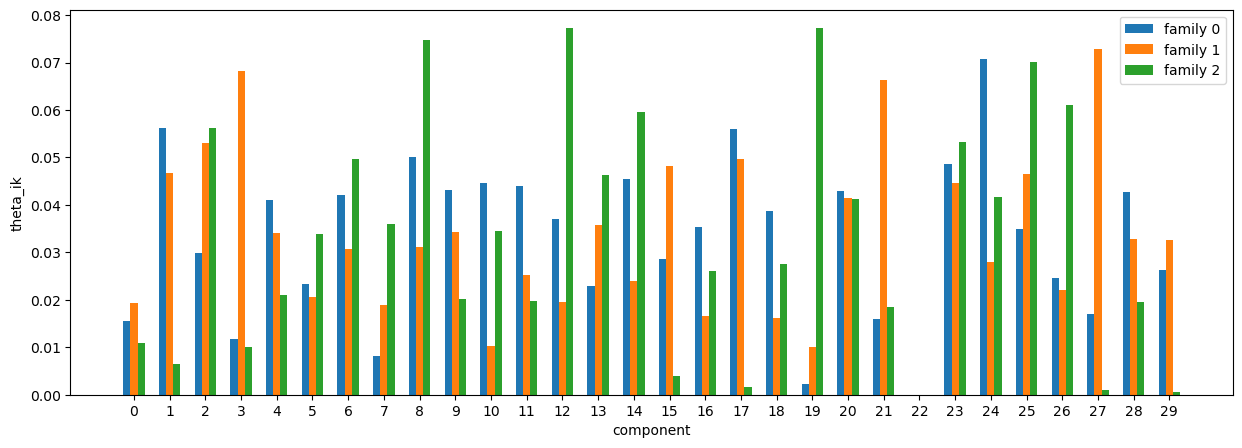

In [46]:
cohorts = ['2', '3', '5']
# colors = ['cyan', 'yellow', 'magenta']

bar_width = 0.2
offset = [0, bar_width, 2 * bar_width]

base_x_pos = np.arange(len(theta[0]))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i, theta_i in enumerate(results[30]['theta']):
    ax.bar(
        base_x_pos + offset[i], theta_i,
        label=f'family {i}',
        # alpha=0.4,
        # color=colors[i],
        width=bar_width
    )
ax.set_xticks([x + bar_width for x in base_x_pos], range(theta.shape[-1]))
ax.legend()
plt.xlabel('component')
plt.ylabel('theta_ik')
plt.show()

In [83]:
theta.argsort(axis=-1)[:, :-6:-1]

<xarray.DataArray 'theta' (theta_dim_0: 3, theta_dim_1: 5)>
array([[24,  1, 17,  8, 23],
       [27,  3, 21,  2, 17],
       [19, 12,  8, 25, 26]])
Coordinates:
    chain        int64 0
    draw         int64 0
  * theta_dim_0  (theta_dim_0) int64 0 1 2
  * theta_dim_1  (theta_dim_1) int64 29 28 27 26 25

In [213]:
days = sorted(df['date'].unique())

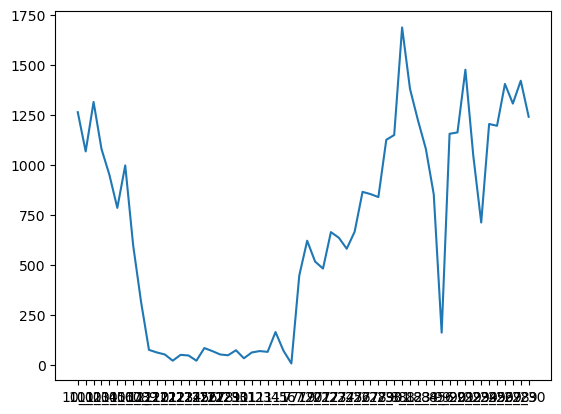

In [211]:
plt.plot(n_assigned_per_day[0])

In [209]:
n_assigned_per_day

z   date
0   10_1    1263
    10_2    1067
    10_3    1314
    10_4    1079
    10_5     950
            ... 
19  9_26     209
    9_27     362
    9_28     784
    9_29     801
    9_30     849
Length: 1189, dtype: int64

### visualize posterior

(array([  2.,  17.,  62., 131., 231., 265., 175.,  86.,  22.,  10.]),
 array([-1.15567 , -1.149582, -1.143494, -1.137406, -1.131318, -1.12523 ,
        -1.119142, -1.113054, -1.106966, -1.100878, -1.09479 ]),
 <BarContainer object of 10 artists>)

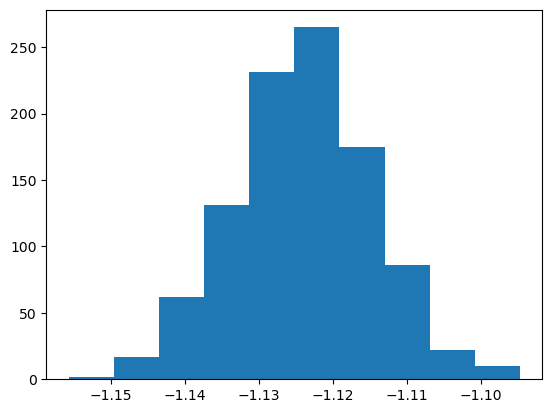

In [43]:
plt.hist(posterior.posterior['beta'][0, :, 0, 0])

/mnt/home/achoudhri/miniconda3/envs/gerbiLDA/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (385) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'theta\n0'}>,
        <AxesSubplot: title={'center': 'theta\n1'}>,
        <AxesSubplot: title={'center': 'theta\n2'}>,
        <AxesSubplot: title={'center': 'theta\n3'}>],
       [<AxesSubplot: title={'center': 'theta\n4'}>,
        <AxesSubplot: title={'center': 'theta\n5'}>,
        <AxesSubplot: title={'center': 'theta\n6'}>,
        <AxesSubplot: title={'center': 'theta\n7'}>],
       [<AxesSubplot: title={'center': 'theta\n8'}>,
        <AxesSubplot: title={'center': 'theta\n9'}>,
        <AxesSubplot: title={'center': 'theta\n10'}>,
        <AxesSubplot: title={'center': 'theta\n11'}>],
       [<AxesSubplot: title={'center': 'theta\n12'}>,
        <AxesSubplot: title={'center': 'theta\n13'}>,
        <AxesSubplot: title={'center': 'theta\n14'}>,
        <AxesSubplot: title={'center': 'theta\n15'}>],
       [<AxesSubplot: title={'center': 'theta\n16'}>,
        <AxesSubplot: title={'center': 'theta\n17'}>,
        <AxesSubplot: title={'cent

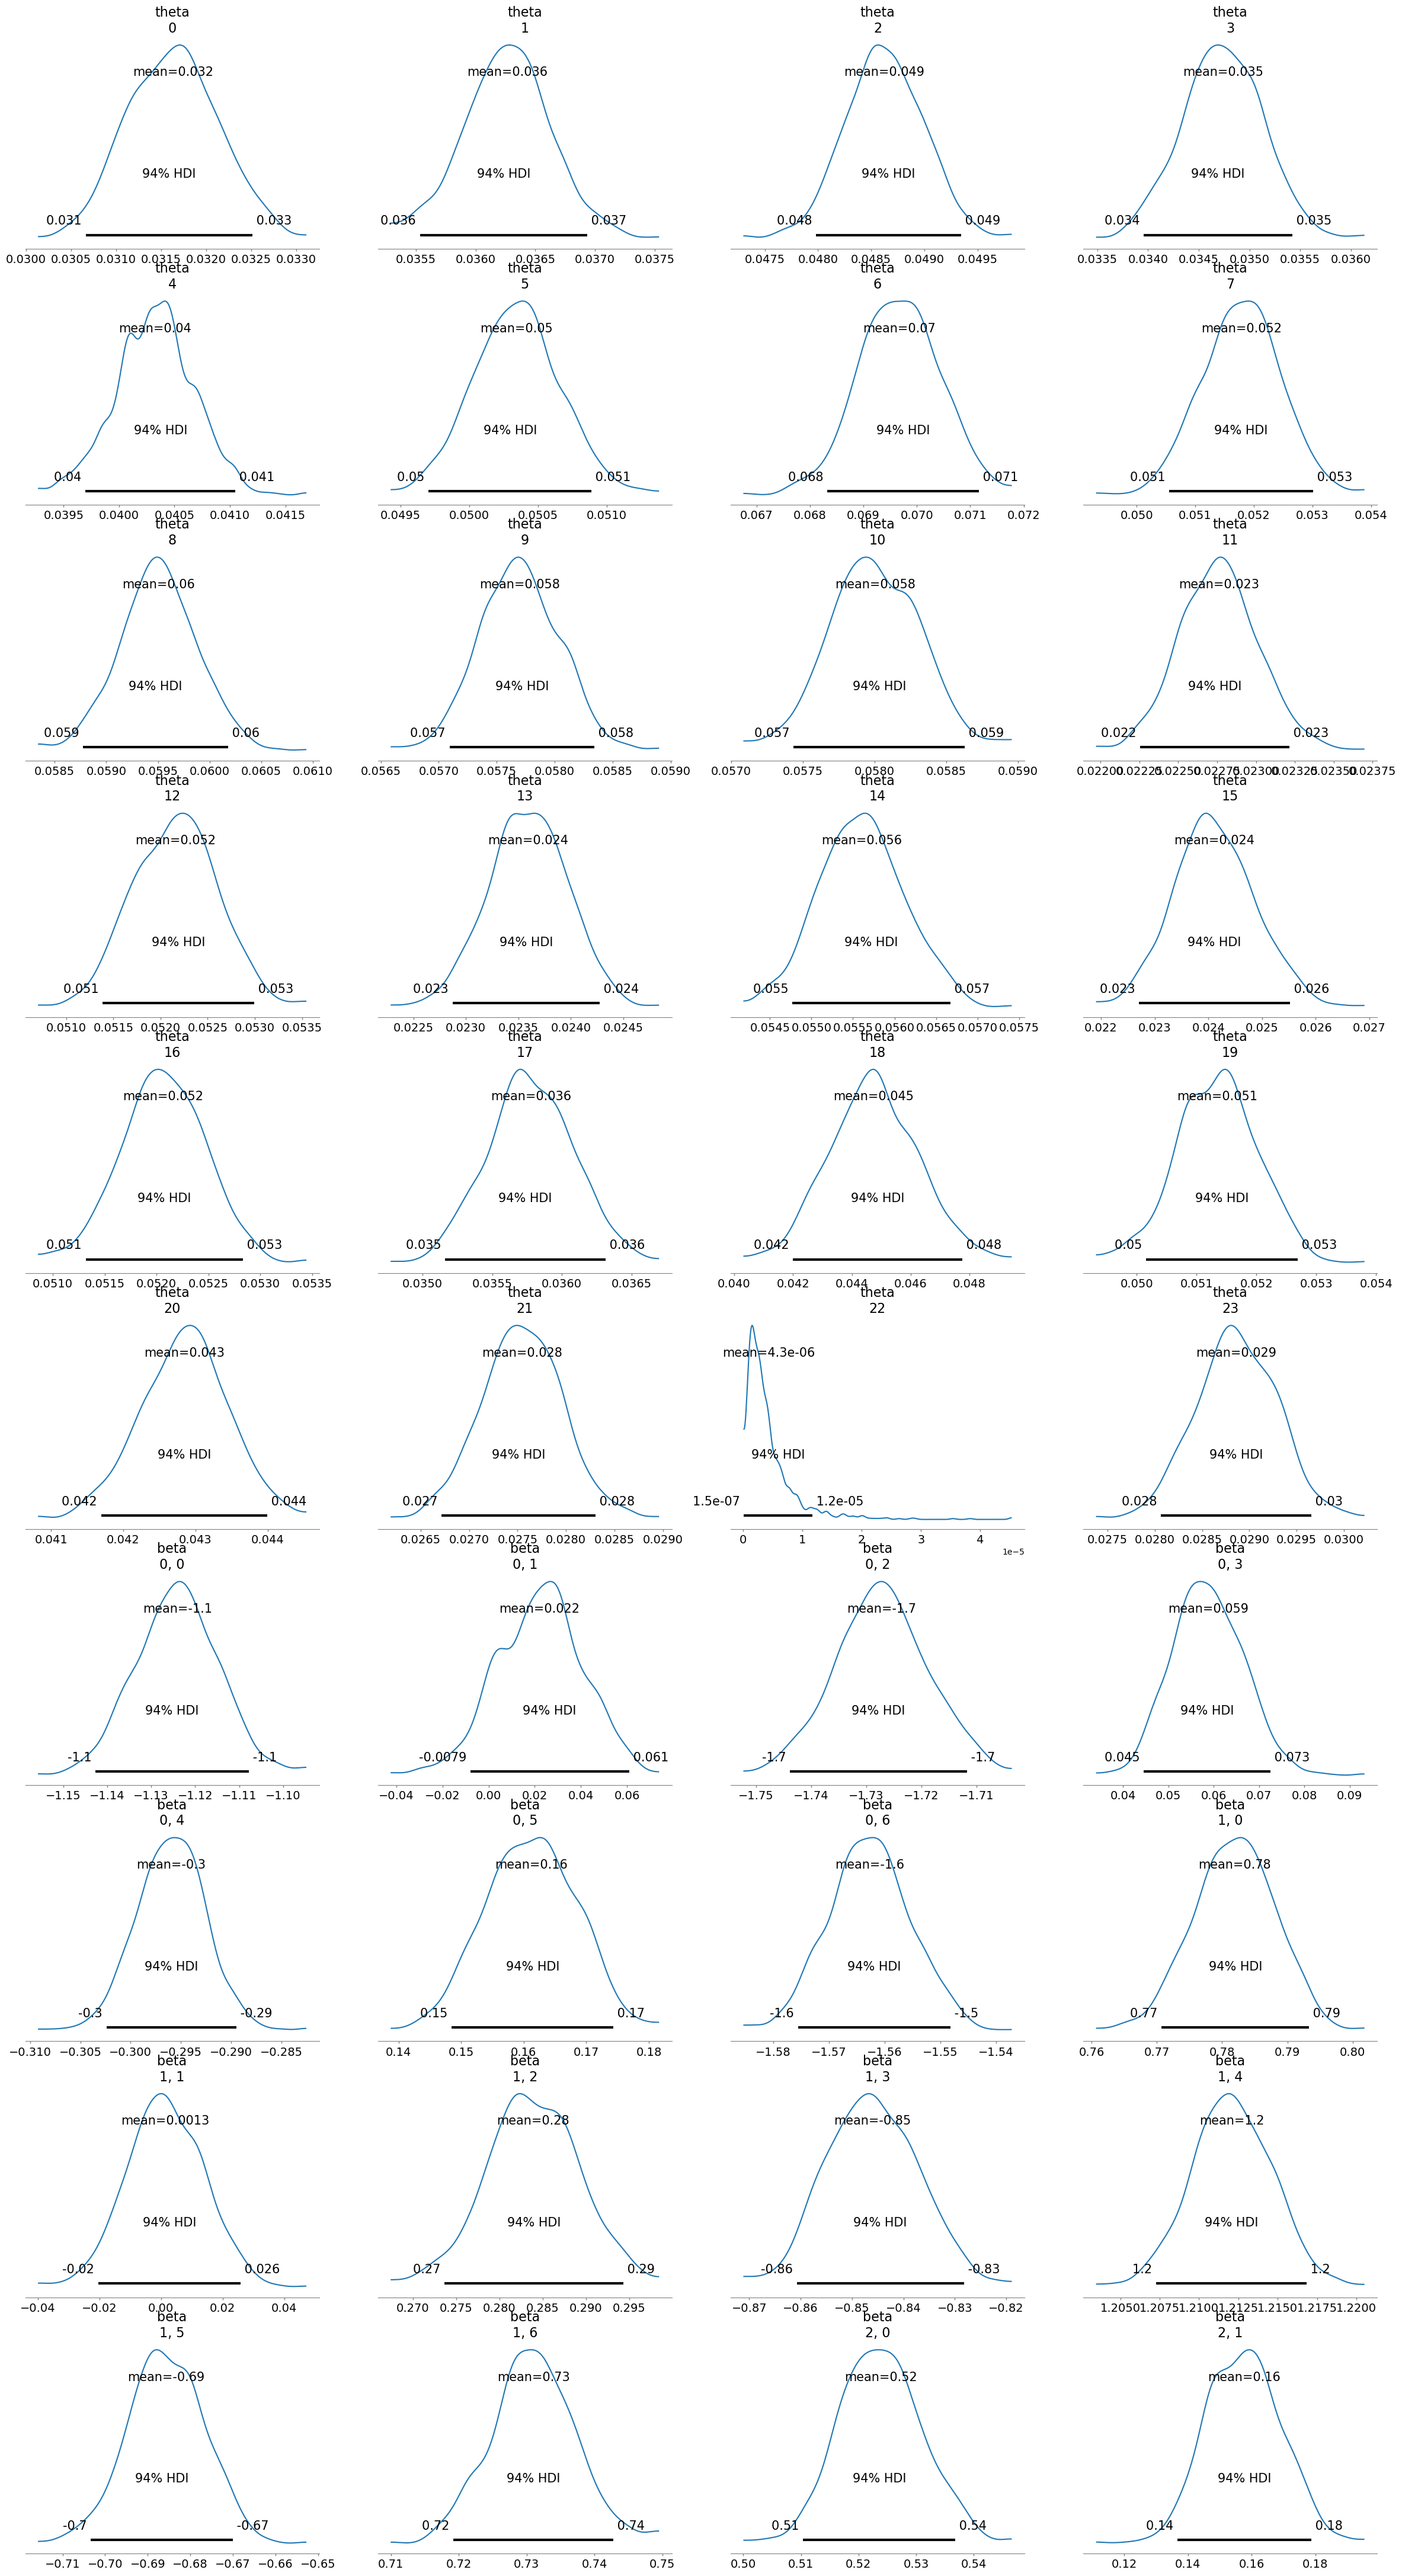

In [44]:
az.plot_posterior(posterior)